In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
from diffusers import UNet2DConditionModel, DDPMScheduler
import torch
from torch.optim import AdamW
from common.dataset import ADNIDatasetSlicesInOrder
from torch.utils.data import DataLoader
from common.utils import load_trained_model, load_trained_embedder, plot_batch_slices, normalise_intensity_per_slice
import numpy as np
import matplotlib.pyplot as plt
from common.sample import sample_next_slices, sample_iteratively, get_index_encoding

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 4

In [4]:
out_dir = "/cim/ehoney/ecse626proj/experiments/experiment12"

In [5]:
data_size = 128
slices_at_once=4
num_train_timesteps=256

In [6]:
model = UNet2DConditionModel(
    sample_size=128,
    in_channels=2*slices_at_once, #16
    out_channels=slices_at_once, #8 #initialise to maximum and compute loss only for indexed slices
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D", "CrossAttnDownBlock2D"),
    mid_block_type=None,
    up_block_types=("CrossAttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
    # not sure about what the lower arguments do
    block_out_channels=(64, 128, 256, 512, 1024), #start with 64? no deeper than 1024
    layers_per_block=2, #default
    cross_attention_dim=1, # ~concat one-hot encodings of condition and target slices~ NO now instead just one 128 vector with labels 0,1,2
    attention_head_dim=8, #default
    norm_num_groups=32, #default
    use_linear_projection=True #DIFFERENT
)
print(f"Model initialised. Number of model parameters: {model.num_parameters()}.")
model.to(device)

Model initialised. Number of model parameters: 286108164.


UNet2DConditionModel(
  (conv_in): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64

In [7]:
noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

In [8]:
load_trained_model(model, os.path.join(out_dir,'latest_ckpt.pth.tar'))

/cim/ehoney/ecse626proj/common/utils.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


Checkpoint loaded from epoch 57.


In [9]:
noised_target_slices = torch.randn(batch_size, slices_at_once, data_size, data_size, device=device)

In [10]:
condition_slices = torch.zeros_like(noised_target_slices)

In [11]:
first_target_slice_indices = torch.zeros(4, dtype=torch.int).to(device)

In [12]:
encoder_hidden_states = get_index_encoding('index', first_target_slice_indices, slices_at_once, None) / data_size

In [13]:
target_slices = sample_next_slices(noised_target_slices, condition_slices, model, noise_scheduler, batch_size, device, encoder_hidden_states, verbose=True)

t is 255
t is 254
t is 253
t is 252
t is 251
t is 250
t is 249
t is 248
t is 247
t is 246
t is 245
t is 244
t is 243
t is 242
t is 241
t is 240
t is 239
t is 238
t is 237
t is 236
t is 235
t is 234
t is 233
t is 232
t is 231
t is 230
t is 229
t is 228
t is 227
t is 226
t is 225
t is 224
t is 223
t is 222
t is 221
t is 220
t is 219
t is 218
t is 217
t is 216
t is 215
t is 214
t is 213
t is 212
t is 211
t is 210
t is 209
t is 208
t is 207
t is 206
t is 205
t is 204
t is 203
t is 202
t is 201
t is 200
t is 199
t is 198
t is 197
t is 196
t is 195
t is 194
t is 193
t is 192
t is 191
t is 190
t is 189
t is 188
t is 187
t is 186
t is 185
t is 184
t is 183
t is 182
t is 181
t is 180
t is 179
t is 178
t is 177
t is 176
t is 175
t is 174
t is 173
t is 172
t is 171
t is 170
t is 169
t is 168
t is 167
t is 166
t is 165
t is 164
t is 163
t is 162
t is 161
t is 160
t is 159
t is 158
t is 157
t is 156
t is 155
t is 154
t is 153
t is 152
t is 151
t is 150
t is 149
t is 148
t is 147
t is 146
t is 145
t

/cim/ehoney/ecse626proj/common/utils.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


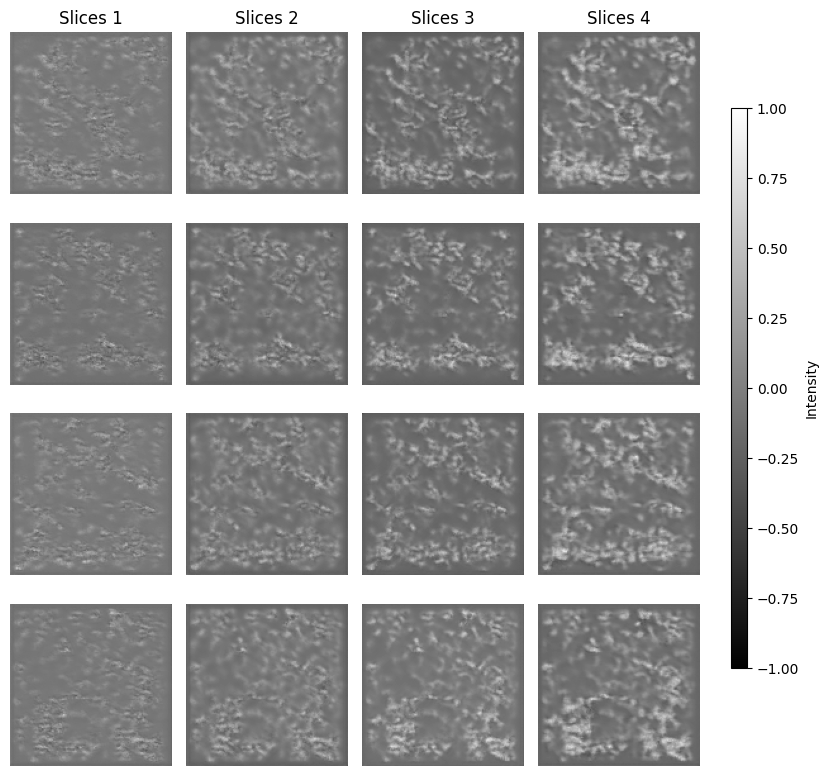

In [14]:
plot_batch_slices(target_slices, batch_size, slices=slices_at_once, vmin=-1)

In [19]:
data_dir = "/cim/ehoney/ecse626proj/preprocessed_data"
train_dataset = ADNIDatasetSlicesInOrder(data_dir, sample_full_brain=True, symmetric_normalisation=True, data_size=data_size)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8) # CHANGE to NUM_WORKERS=4

In [20]:
one_batch = next(iter(train_dataloader))

In [23]:
condition_start_index = 64

Condition slices populated from slice 64 to 68.


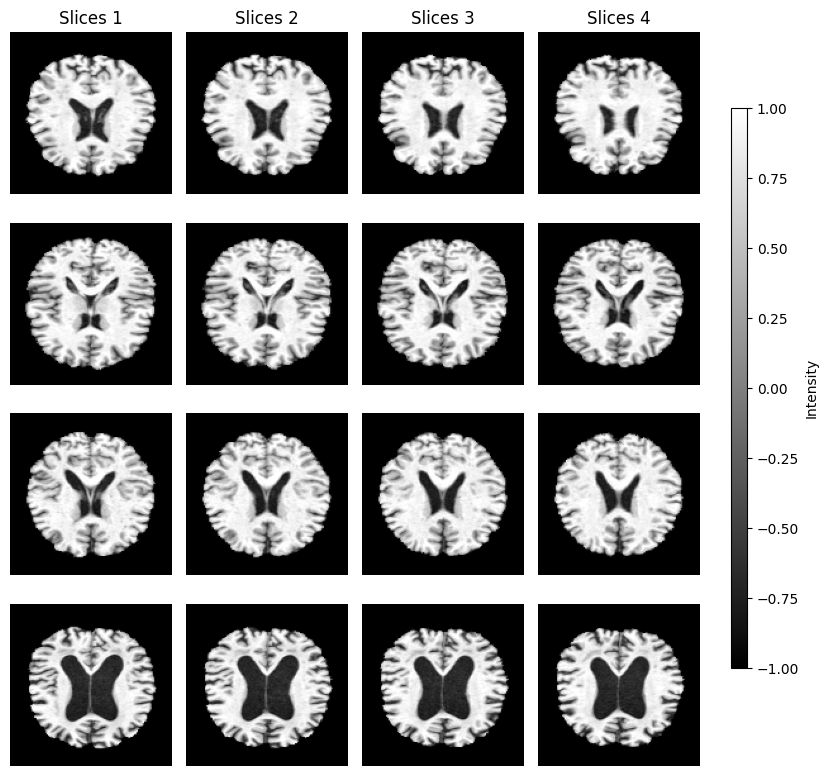

Sampling slices 68 to 72...
Generated slices in range [(tensor(-0.9920, device='cuda:0'), tensor(1., device='cuda:0'))]


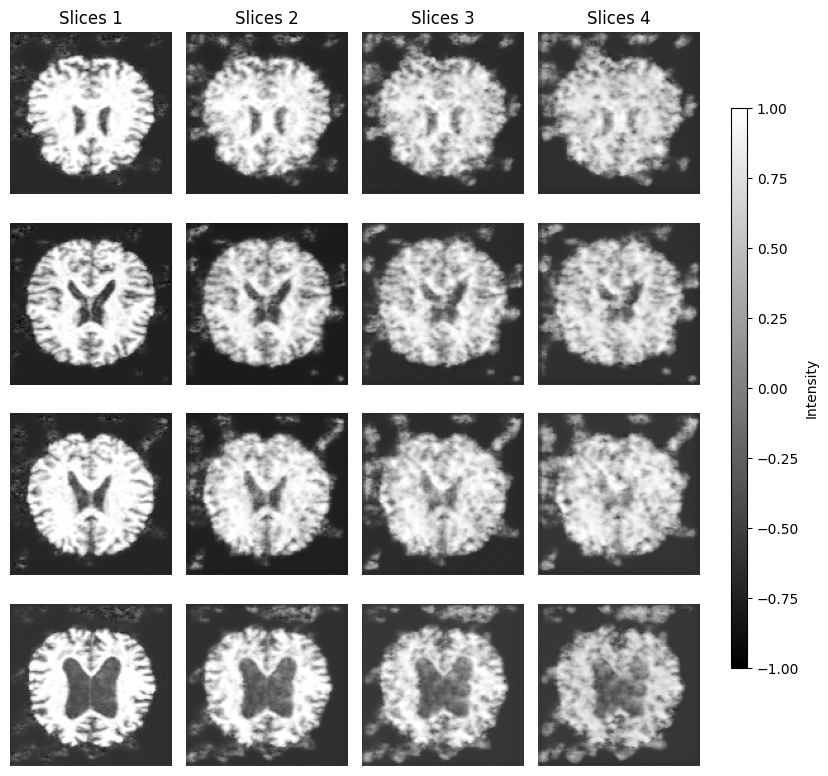

Complete.
Sampling slices 72 to 76...
Generated slices in range [(tensor(-0.8759, device='cuda:0'), tensor(1., device='cuda:0'))]


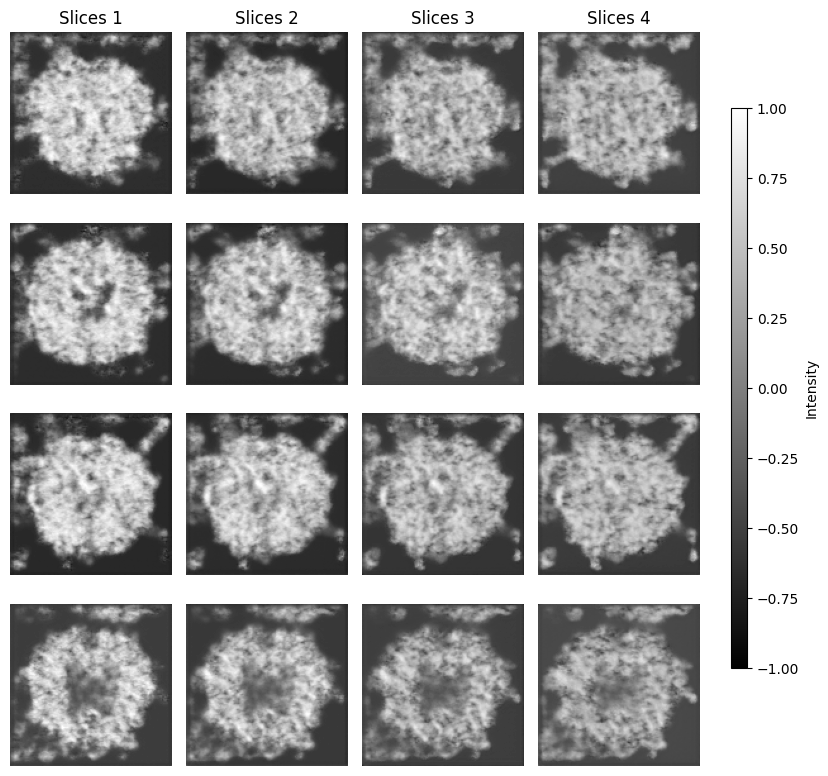

Complete.
Sampling slices 76 to 80...
Generated slices in range [(tensor(-0.8507, device='cuda:0'), tensor(1., device='cuda:0'))]


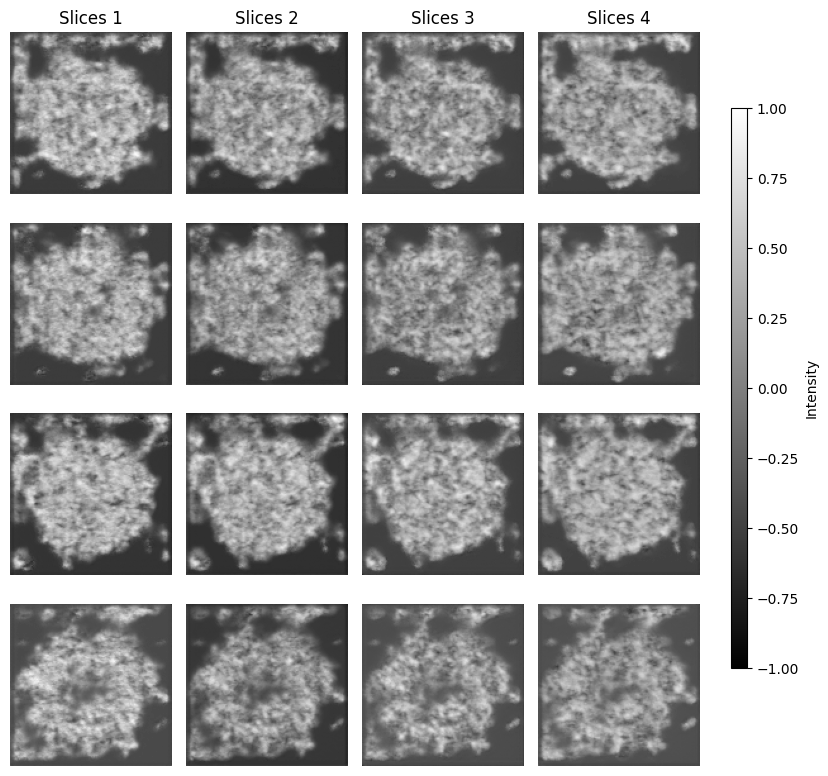

Complete.
Sampling slices 80 to 84...
Generated slices in range [(tensor(-0.7816, device='cuda:0'), tensor(1., device='cuda:0'))]


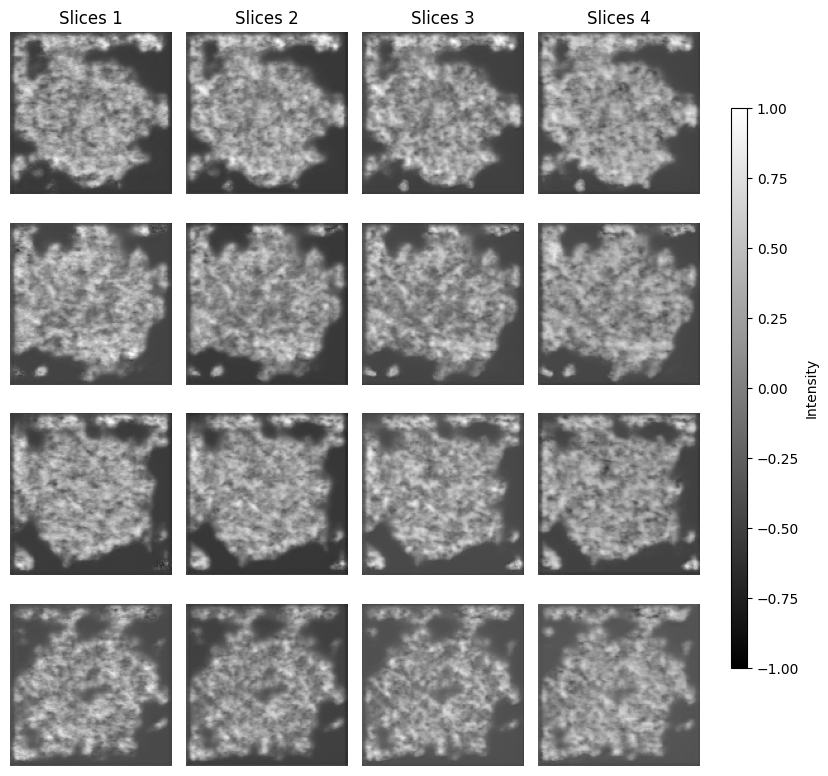

Complete.
Sampling slices 84 to 88...
Generated slices in range [(tensor(-0.8019, device='cuda:0'), tensor(1., device='cuda:0'))]


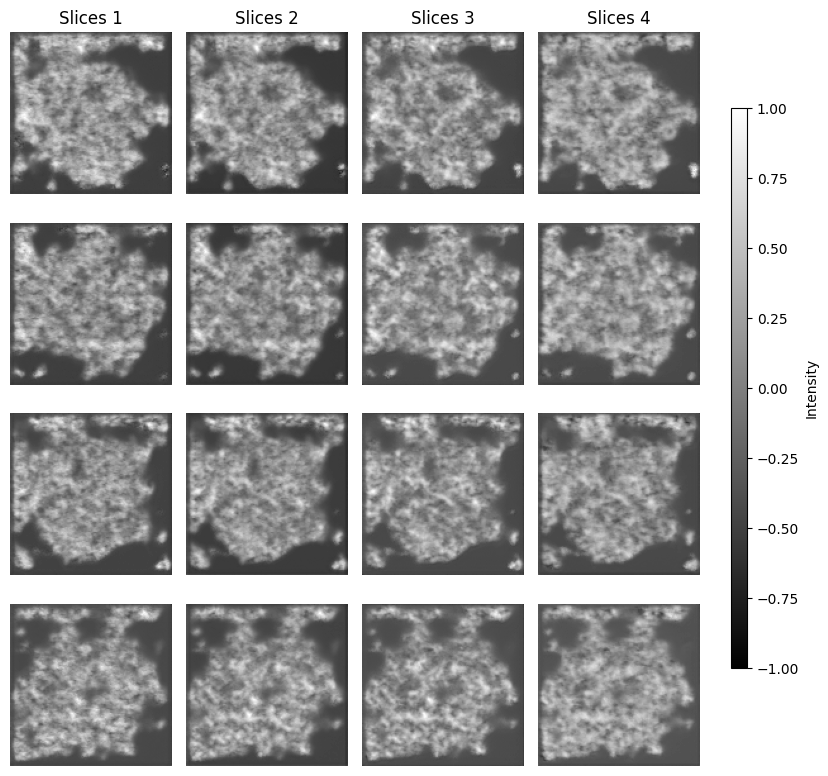

Complete.
Sampling slices 88 to 92...


KeyboardInterrupt: 

In [24]:
output_batch = sample_iteratively(condition_start_index, slices_at_once, one_batch, model, noise_scheduler, None, batch_size, device, symmetric_normalisation=True, index_encoding_type='index', verbose=True)